# High Frequency Flow Data: Flashiness Index Value and Hysteresis Plots

This lesson was adapted from educational material written by [Dr. Kateri Salk](https://www.hydroshare.org/user/4912/) for her Fall 2019 Hydrologic Data Analysis course at Duke University. This is the second part of a two-part exercise focusing on high frequency flow data. 

## Introduction 
**Flashiness** is how responsive a stream is to precipitation. Flashiness is an important characteristic of the stream hydrologic regime. A "flashy" stream is one that experiences a rapid increase in flow shortly after onset of a precipitation event, and an equally rapid return to base conditions shortly after the end of the precipitation event. A "flashy" stream will thus increase in stormflow much faster following a precipitation event.


## Learning Objectives

After successfully completing this notebook, you will be able to:
1. Calculate the Flashiness Index Value of a river
2. Use a hysteresis plot to understand watershed dynamics
3. Communicate findings with peers through oral, visual, and written modes

## Requirements to Complete Lesson 

### Packages
This lesson requires the installation of the following R packages to run the provided script:
- `ggplot2`- Version 3.3.3. Creates elegant data visualisations using the Grammar of Graphics.
- `tidyverse`- Version 1.3.0. A collection of R packages designed for data science.
- `lubridate`- Version 1.7.9. Functions for working with dates/times.
- `scales`- Version 1.1.1. Graphical scales provide methods for automatically determining breaks and labels for axes and legends.
- `dataRetrival`- Version 2.7.6. Retrieval Functions for USGS and EPA Hydrologic and Water Quality Data.
- `xts`- Version 0.12.1. Provides for uniform handling of R's different time-based data classes by extending zoo, maximizing native format information preservation and allowing for user level customization and extension, while simplifying cross-class interoperability.
- `dygraphs`- Version 1.1.1.6. R interface for the dygraphs Javascript charting library. Provides rich facilities for charting time-series data in R, including highly configurable series- and axis-display and interactive features like zoom/pan and series/point highlighting.
- `Cairo` - Version 1.5-12.2. R graphics device using cairographics library that can be used to create high-quality vector (PDF, PostScript and SVG) and bitmap output (PNG,JPEG,TIFF), and high-quality rendering in displays (X11 and Win32).

### Data and Code 

This lesson will import instantaneous value data from the National Water Information System for Third Fork Creek and Ellerbe Creek in North Carolina for the entire period of record using the `dataRetrieval` package. The package was created to make querying and downloading hydrologic data from the USGS National Water Information System (NWIS) and the multi-agency database, Water Quality Portal (WQP) easier. NWIS contains streamflow, peak flow, rating curves, groundwater, and water quality data data collected by or for the USGS. WQP only contains water quality data.

It should be noted that the databases are not static as data is constantly being added.  For more in-depth information on the `dataRetrieval` package, please visit https://cran.r-project.org/web/packages/dataRetrieval/vignettes/dataRetrieval.html. 

The code provided in this resource was developed using R version 3.6.1. 

### Set Working Directory 

In R, the working directory is the directory where R starts when looking for any file to open (as directed by a file path) and where it saves any output. This lesson assumes that you have set your working directory to the folder location of the downloaded and unzipped data subsets.

### Load packages and set ggplot theme

In [15]:
library(Cairo)
library(dataRetrieval)
library(shiny)
library(tidyverse)
library(xts)
library(dygraphs)
library(ggplot2)
library(scales)

theme_set(theme_gray()) 

## Richards-Baker Index

The Richards-Baker Index is an quantitative index of how flashy a stream is. It reports changes in short term daily flows relative to average yearly flows. When stormwater
flows into creeks at a higher volume and at a faster rate relative to natural conditions, the R-B flashiness index increases.  
It is calculated as:
**RBI = (\sum_{j = 1}^n |Q_j - Q_{j-1}| / \sum_{j = 1}^n Q_j) / Catchment Area**

Flashiness in a stream can be increased or decreased by a variety of land use/land cover changes in the stream's watershed. For example, an increase in impervious surfaces (urbanization) or agricultural land typically leads to an increase in flashiness. Land management practices that increase infiltration of precipitation into the soil, such as restoration of native vegetation, or implementation of best management practices like rain gardens, grass swales, and forested riparian buffers, typically decrease stream flashiness. 

## From Part 1: Import Instantaneous Flow Data from Third Fork Creek and Ellerbe Creek 

In [16]:
dischargedatTFC2018 <- readNWISuv(
  site = "02097280", #Third Fork Creek at Woodcroft Parkway Near Blands NC
  parameterCd = "00060", #Discharge in cfs 
  startDate = "2018-01-01", 
  endDate = "2019-01-01"
  ) %>% 
  renameNWISColumns()

head(dischargedatTFC2018)

,agency_cd,site_no,dateTime,Flow_Inst,Flow_Inst_cd,tz_cd
,<chr>,<chr>,<dttm>,<dbl>,<chr>,<chr>
1,USGS,02097280,2018-01-01 05:00:00,1.83,A,UTC
2,USGS,02097280,2018-01-01 05:15:00,2.01,A,UTC
3,USGS,02097280,2018-01-01 05:30:00,2.01,A,UTC
4,USGS,02097280,2018-01-01 05:45:00,2.01,A,UTC
5,USGS,02097280,2018-01-01 06:00:00,2.01,A,UTC
6,USGS,02097280,2018-01-01 06:15:00,2.01,A,UTC


In [17]:
dischargedatEC2018 <- readNWISuv(
  site = "0208675010", #Ellerbe Creek at Club Boulevard at Durham, NC
  parameterCd = c("00060","99133"), #Discharge in cfs & Nitrate in mg/l NO3-N
  startDate = "2018-01-01", 
  endDate = "2019-01-01"
  ) %>% 
 
 renameNWISColumns()

head(dischargedatEC2018)


,agency_cd,site_no,dateTime,Flow_Inst,Flow_Inst_cd,tz_cd
,<chr>,<chr>,<dttm>,<dbl>,<chr>,<chr>
1,USGS,0208675010,2018-01-01 05:00:00,0.46,A,UTC
2,USGS,0208675010,2018-01-01 05:15:00,0.46,A,UTC
3,USGS,0208675010,2018-01-01 05:30:00,0.46,A,UTC
4,USGS,0208675010,2018-01-01 05:45:00,0.46,A,UTC
5,USGS,0208675010,2018-01-01 06:00:00,0.46,A,UTC
6,USGS,0208675010,2018-01-01 06:15:00,0.46,A,UTC


## Calculate Flashiness Index Value of Third Fork Creek 
First we will pull in metadata for Third Fork Creek using the `readNWISsite` function. We need the drainage area of Third Fork Creek in square miles from the metadata, which is also known as the catchment size. Then we will use the Richards-Baker Index equation to calculate the Flashiness Index Value. 

In [18]:
TFCsitedata <- readNWISsite(site = "02097280")
TFC.catchment.size <- TFCsitedata$drain_area_va #square miles
TFC.catchment.size 

[1] 14.79

In [19]:
RBI_TFC2018 <- (
  sum(abs(diff(dischargedatTFC2018$Flow_Inst))) / 
    sum(dischargedatTFC2018$Flow_Inst[-1])
  ) / TFC.catchment.size

In [20]:
RBI_TFC2018

[1] 0.00303721

>Flashiness Index Value of Third Fork Creek is 0.003

## Calculate Flashiness Index Value of Ellerbe Creek

In [21]:
ECsitedata <- readNWISsite(site = "0208675010")
EC.catchment.size <- ECsitedata$drain_area_va #square miles
EC.catchment.size

[1] 6.01

In [22]:
RBI_EC2018 <- (
  sum(abs(diff(dischargedatEC2018$Flow_Inst))) / 
    sum(dischargedatEC2018$Flow_Inst[-1])
  ) / EC.catchment.size 

In [23]:
RBI_EC2018

[1] 0.01220736

>Flashiness Index Value of Ellerbe Creek is 0.012

Smaller catchment areas are flashier because it takes less time for water to reach the stream. Bigger catchment area will have less immediate changes than a smaller catchment. We can see that Ellerbe Creek has a smaller catchment size than Third Fork Creek, and therefore has a larger Flashiness Index Value. 

## Hysteresis Loops

Hysteresis occurs when the concentration varies with discharge in a different relationship on the rising and falling limbs of a storm. This can be caused by **flushing** behavior or **dilution** behavior. The direction or rotational pattern of the C-Q hysteresis indicates whether concentration increases or
decreases with discharge. 

**Clockwise hysteresis** occurs when higher concentrations are measured on the rising limb compared to the falling limb of the hydrograph as a result of rapid flushing and exhaustion of
material from the within-channel or next to-channel sources (Bieroza & Heathwaite, 2015; van der Perk,
2006). In contrast, **anticlockwise hysteresis** is typically associated with delayed solute or particulate delivery from distant upstream tributaries or deeper subsurface zones (Bieroza & Heathwaite, 2015; Gellis, 2013). The slope of the hysteresis loop reflects the direction of the C-Q relationship: negative slopes indicate solute
dilution whereas a positive slope is indicative of solute flushing (Butturini et al., 2006).


### Import Instantaneous Flow Data and Nitrate Data from the Potomac River 

In [24]:
Potdat <- readNWISuv(
  site = "01646500", # POTOMAC RIVER NEAR WASH, DC LITTLE FALLS PUMP STATION
  parameterCd = c("00060", "99133"), # Discharge=Instantaneous Flow in cfs & Nitrate in mg/l NO3-N
  startDate = "2016-01-1",
  endDate = "2017-01-01"
  ) %>% 
  renameNWISColumns() %>%
  rename(Nitrate_mgl = 6)

### Compare Instantaneous Flow vs. Nitrate concentrations at the Potomac River

Warning message:
“Removed 3564 rows containing missing values (geom_point).”


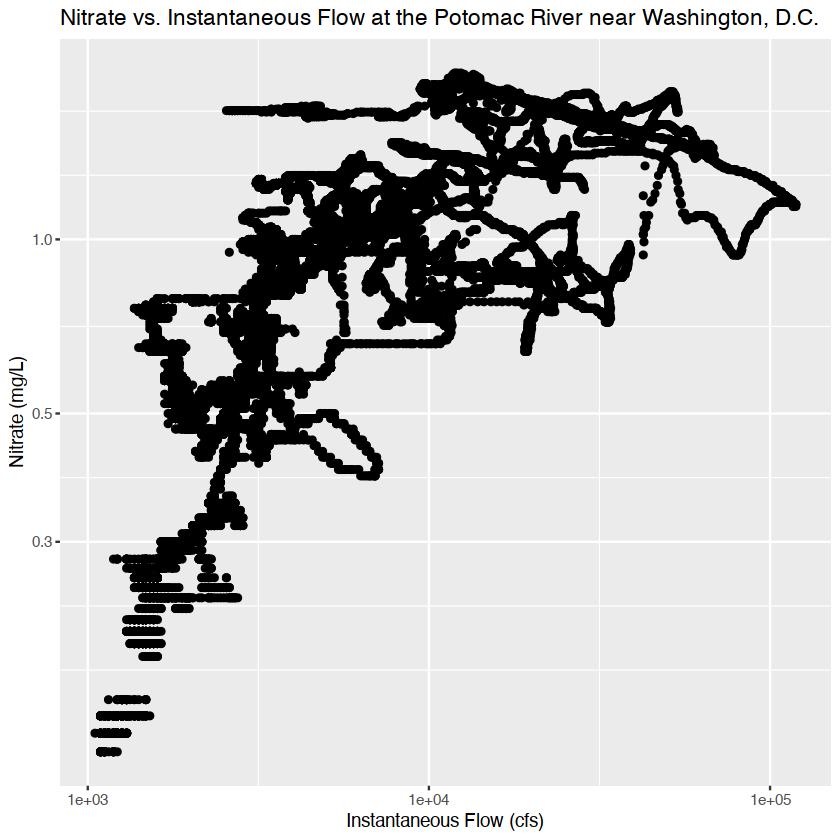

In [25]:
ggplot(Potdat,
       aes(x = Flow_Inst, y = Nitrate_mgl)) +
  geom_point() +
  scale_x_log10() +
  scale_y_log10()+
  xlab("Instantaneous Flow (cfs)")+
ylab("Nitrate (mg/L)")+
ggtitle("Nitrate vs. Instantaneous Flow at the Potomac River near Washington, D.C.")

In [26]:
dygraph(xlab="Date", ylab = "Instantaneous Flow (ft3/s)", main = "Instantaneous Flow and Nitrate Concentration at the Potomac River near Washington D.C.",
  cbind(
    Flow = xts(Potdat$Flow_Inst, order.by = Potdat$dateTime), 
    Nitrate = xts(Potdat$Nitrate_mgl, order.by = Potdat$dateTime)
    )
  ) %>% 
  dySeries("Nitrate", axis = "y2") %>%
  dyRangeSelector()

HTML widgets cannot be represented in plain text (need html)

Look at the storm that occurred around February 1st. Do you expect this storm to be a flushing or a diluting storm?

>

## Graph Instantaneous Flow vs. Nitrate Concentration for storm occurring on 2/1/2016
Filter the dates from 2016-01-31 to 2016-02-14 to capture the entire storm event. 

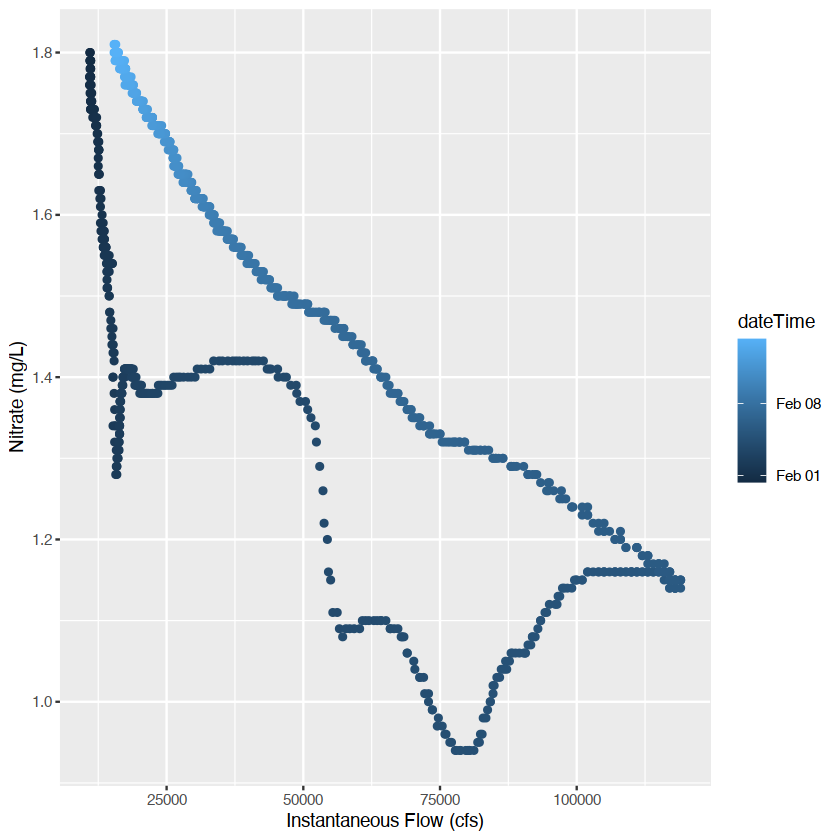

In [27]:
PotomacStorm <- Potdat %>%
  filter(dateTime > "2016-01-31" & dateTime < "2016-02-14") 

ggplot(PotomacStorm, aes(x = Flow_Inst, y = Nitrate_mgl, color = dateTime)) +
  geom_point()+
 xlab("Instantaneous Flow (cfs)")+
ylab("Nitrate (mg/L)")

Did this storm exhibit clockwise or counterclockwise hysteresis?

>

Which direction do hysteresis loops go for diluting storms?

>

Which direction do hysteresis loops go for flushing storms?

>